In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm
from matplotlib.pyplot import cm
import matplotlib
from matplotlib.gridspec import GridSpec

import xesmf as xe
#from pykrige.ok import OrdinaryKrigingg
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils
import os

import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs

import geopandas

In [2]:
###### TO DO:
########### CO2 is this the correct values
########### supplemental material
########### conclusion
########### more lit on coal in china

In [3]:
years = 50
countries = ['MALAYSIA','CAMBODIA','INDONESIA','VIETNAM']
## Add time dimension
length_simulation = years*365
time_array = np.arange(0, length_simulation)
shutdown_years = np.arange(2000,2061,1)
## Days per season
season_days = {'DJF': 90, 'MAM':92, 'JJA':92, 'SON':91}


In [4]:


## import the china global powerplant database
### Gallagher, Kevin P. (2021), “China’s Global Energy Finance,” Global Development Policy Center, Boston University.
### Gallagher, Kevin P., Li, Zhongshu, Chen, Xu, Ma, Xinyue (2019), “China’s Global Power Database,” Global Development Policy Center, Boston University.

CGP_df = pd.read_csv('mod_coal_inputs/BC_limited_country_SEA_GAINS_Springer.csv')


CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})
min_year = CGP_df['Year_of_Commission'].min()
## reduce to one country for emissions
print('Emis data prepped and loaded')


######## Country mask and dataframe ######

country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_50
country_df = geopandas.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
impacted_countries = ['China','Australia', 'India','Myanmar',  'Laos','Philippines','Nepal','Bangladesh','Thailand','Bhutan','Brunei', 'Papua New Guinea', 'Solomon Islands', 'East Timor', 'Taiwan']
country_df = country_df.rename(columns = {'SOVEREIGNT':'country'})

ds_area = xr.open_dataset('/net/fs11/d0/emfreese/GCrundirs/IRF_runs/stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4', engine = 'netcdf4')
utils.fix_area_ij_latlon(ds_area);


Emis data prepped and loaded


In [5]:
Tg_per_kg = 1e9
rad_force_dict = {'MALAYSIA': 1.32e-2/Tg_per_kg, 'INDONESIA':1.17e-2/Tg_per_kg, 'VIETNAM':1.30e-2/Tg_per_kg, 'CAMBODIA':1.81e-2/Tg_per_kg} #units = W/m2/Tg  BC

In [6]:
for c in rad_force_dict.keys():
    CGP_df.loc[CGP_df['COUNTRY'] == c,'rad_forcing_wperm2perkg'] = rad_force_dict[c]

In [7]:

####### Functions #########

def individual_plant_shutdown(years_running, df, time_array, typical_shutdown_years, unique_id):
    ''' Shutdown a unit early. The df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day
        years_running is the number of years the plant runs
        time_array is the length of time for our simulation
        shutdown_years is the typical lifetime of a coal plant
        unique_id is the unique identifier of a unit'''
    shutdown_days = typical_shutdown_years*365
    E = np.zeros(len(time_array))
    new_CGP = df.loc[df['unique_ID'] == unique_id]
    yr_offset = (new_CGP['Year_of_Commission'].iloc[0] - min_year)
    test_array = np.where((time_array <= (yr_offset + years_running)*365) & (time_array >= yr_offset * 365), True, False)
    E += test_array* new_CGP['BC_(g/day)'].sum()
    return(E)






####### Functions #########

def year_plant_shutdown(years_running, df, time_array, typical_shutdown_years, unique_id):
    ''' Shutdown a unit early. The df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day
        years_running is the number of years the plant runs
        time_array is the length of time for our simulation
        shutdown_years is the typical lifetime of a coal plant
        unique_id is the unique identifier of a unit'''
    shutdown_days = typical_shutdown_years*365
    E = np.zeros(len(time_array))
    new_CGP = df.loc[df['unique_ID'] == unique_id]
    yr_offset = CGP_df.loc[(CGP_df['BC_(g/day)'] >0) & (CGP_df['unique_ID'] == unique_id)]['Year_of_Commission'].iloc[0] - min_year
    test_array = np.where((time_array <= (yr_offset + typical_shutdown_years)*365) & (time_array >= yr_offset * 365), True, False)
    E += test_array* new_CGP['BC_(g/day)'].sum()
    return(E)





E_CO2_all_opts = {}

for yr in shutdown_years:
    E_CO2_all_opts[yr] = {}
    for unique_id in CGP_df.loc[CGP_df['BC_(g/day)'] >0]['unique_ID'].values:
        E_CO2_all_opts[yr][unique_id] = ((yr- CGP_df.loc[(CGP_df['BC_(g/day)'] >0) & (CGP_df['unique_ID'] == unique_id)]['Year_of_Commission'] )* 
                                            CGP_df.loc[(CGP_df['BC_(g/day)'] >0) & (CGP_df['unique_ID'] == unique_id)]['BC_(g/day)']).sum()
        if E_CO2_all_opts[yr][unique_id] < 0:
            E_CO2_all_opts[yr][unique_id] = 0
        E_CO2_all_opts[yr][unique_id] = xr.DataArray(data = E_CO2_all_opts[yr][unique_id],
            dims = ['unique_id'],
            coords = dict(year = CGP_df.loc[(CGP_df['BC_(g/day)'] >0)].unique_ID),
            attrs = dict(description = 'emissions of BC',
                        units = 'kg/m2'))

In [8]:
unique_df = CGP_df.groupby('unique_ID').sum()

In [9]:
E_CO2_all_opts = {}
Emis_CO2_all_opts = {}
unique_ds = xr.DataArray(data = unique_df.loc[(unique_df['BC_(g/day)'] >0)]['BC_(g/day)'].values,
                        dims = ['unique_ID'],
                        coords = dict(unique_ID = 
                                      unique_df.loc[(unique_df['BC_(g/day)'] >0)].index),
                        attrs = dict(description = 'emissions of BC',
                                    units = 'kg/m2'))

for yr in shutdown_years:
    E_CO2_all_opts[yr] = ((yr- unique_df.loc[(unique_df['BC_(g/day)'] >0)]['Year_of_Commission'] ))

    E_CO2_all_opts[yr] = xr.DataArray(data = E_CO2_all_opts[yr].values,
    dims = ['unique_ID'],
    coords = dict(unique_ID = 
                  unique_df.loc[(unique_df['BC_(g/day)'] >0)].index),
    attrs = dict(description = 'emissions of BC',
                units = 'kg/m2'))
    

    
    E_CO2_all_opts[yr] = E_CO2_all_opts[yr].where(E_CO2_all_opts[yr] > 0).fillna(0)
    E_CO2_all_opts[yr] = E_CO2_all_opts[yr].where(E_CO2_all_opts[yr] <= 40).fillna(40)
    Emis_CO2_all_opts[yr] = E_CO2_all_opts[yr]*unique_ds
    


########## Create emissions profile for each plant over our shutdown times ##########
shutdown_years = np.arange(10,41,1)
E_CO2_all_opts = {}
for year in shutdown_years:
    E_CO2_all_opts[year] = {}
    for unique_id in CGP_df.loc[CGP_df['BC_(g/day)'] >0]['unique_ID'].values:
        E_CO2_all_opts[year][unique_id] = individual_plant_shutdown(year, CGP_df, time_array, 40, unique_id)
        E_CO2_all_opts[year][unique_id] = xr.DataArray(data = E_CO2_all_opts[year][unique_id],
            dims = ['year'],
            coords = dict(year = time_array),
            attrs = dict(description = 'emissions of BC',
                        units = 'kg/m2'))
print('Emissions profiles based on weighted capacity of CO2 emissions percentiles created')



########## Create emissions profile for each plant over our shutdown times ##########
shutdown_years = np.arange(10,41,1)
E_CO2_all_opts = {}
for year in np.arange(2000,2060,1):
    E_CO2_all_opts[year] = {}
    for unique_id in CGP_df.loc[CGP_df['BC_(g/day)'] >0]['unique_ID'].values:
        E_CO2_all_opts[year][unique_id] = year_plant_shutdown(year, CGP_df, time_array, 40, unique_id)
        E_CO2_all_opts[year][unique_id] = xr.DataArray(data = E_CO2_all_opts[year][unique_id],
            dims = ['year'],
            coords = dict(year = time_array),
            attrs = dict(description = 'emissions of BC',
                        units = 'kg/m2'))
print('Emissions profiles based on weighted capacity of CO2 emissions percentiles created')


In [10]:
country_id_ds = CGP_df.loc[CGP_df['BC_(g/day)'] >0][['COUNTRY','unique_ID','CO2_weighted_capacity_1000tonsperMW', 'ANNUALCO2', 'MW',
                                                      'CON.COUNTRY', 'PAR.COUNTRY', 'AE.COUNTRY','Year_of_Commission', 'rad_forcing_wperm2perkg']].groupby('unique_ID').first().to_xarray()

In [11]:
# E_dict = {}
# for m in E_CO2_all_opts.keys():
#     E_dict[m] = xr.concat([E_CO2_all_opts[m][t] for t in E_CO2_all_opts[m].keys()], pd.Index([t for t in E_CO2_all_opts[m].keys()], name='unique_ID'), join = 'outer')

E_ds = xr.concat([E_CO2_all_opts[m] for m in E_CO2_all_opts.keys()], pd.Index([m for m in E_CO2_all_opts.keys()], name='closure_year'), join = 'outer')
Emis_ds = xr.concat([Emis_CO2_all_opts[m] for m in Emis_CO2_all_opts.keys()], pd.Index([m for m in Emis_CO2_all_opts.keys()], name='closure_year'), join = 'outer')


In [12]:
final_E_ds = xr.ones_like(E_ds)*40

In [13]:
ug_to_ng = 1e3

In [14]:
######### import the convolutions ###############
conv_df = {}
for c in countries:
    for unique_id in CGP_df.loc[(CGP_df['COUNTRY'] == c) & (CGP_df['BC_(g/day)'] >0)]['unique_ID'].values:
        #if os.path.exists(f'Outputs/individual_shutdowns/single_year/C_out_{c}_{unique_id}_uniqueid_single_yr.nc'):
        conv_df[unique_id] = pd.read_csv(f'Outputs/individual_shutdowns/single_year/C_out_{c}_{unique_id}_uniqueid_single_yr.nc', index_col = 0)
        conv_df[unique_id] = conv_df[unique_id].to_xarray().rename({'index':'country_impacted'})

In [15]:
conv_ds = xr.concat([conv_df[t] for t in conv_df.keys()], pd.Index([t for t in conv_df.keys()], name='unique_ID'), join = 'outer')*ug_to_ng


In [16]:
E_ds.name = 'emis_profiles'
final_E_ds.name = 'final_emis_profiles'

In [17]:
E_ds.attrs['units'] = 'none'
final_E_ds.attrs['units'] = 'none'

In [18]:
co2_ds = E_ds*country_id_ds['ANNUALCO2']
co2_ds.name = 'co2_emissions'

final_co2_ds = final_E_ds*country_id_ds['ANNUALCO2']
final_co2_ds.name = 'final_co2_emissions'

In [19]:
mw_ds = E_ds*country_id_ds['MW']
mw_ds.name = 'MW_total'

final_MW_ds = final_E_ds*country_id_ds['MW']
final_MW_ds.name = 'final_MW_total'

INDIA NDE  2.61E-02

INDON IDN  1.17E-02

THAIL THA 1.45E-02 

MALYS MYS  1.32E-02 

PHIL PHL 8.79E-03 

VTNAM VNM  1.30E-02 

REST OF EAS RSEA  1.81E-02 

In [20]:
Emis_ds.name = 'BC_emissions'

rad_force_ds = country_id_ds['rad_forcing_wperm2perkg']*Emis_ds

k_per_tg_per_yr = 0.04 #https://acp-copernicus-org.libproxy.mit.edu/articles/20/3079/2020/ Sand et al.
temp_ds = Emis_ds/Tg_per_kg

rad_force_ds.name = 'BC_forcing'
rad_force_ds.attrs = {'units':'W/m2'}

temp_ds.name = 'BC_temp'
temp_ds.attrs = {'units':'K'} 

In [21]:
full_ds = xr.merge([country_id_ds, E_ds*conv_ds,  (final_E_ds*conv_ds).rename({'BC_mean_Conc':'final_BC_mean_Conc', 'BC_pop_weight_mean_conc':'final_BC_pop_weight_mean_conc'}), co2_ds, final_co2_ds, mw_ds, final_MW_ds]).rename({'COUNTRY':'country_emitting'})

#convert to ng/m3 (from ng/m3/yr)
delta_t = full_ds['closure_year'].max().values - min_year
for val in ['BC_mean_Conc', 'BC_pop_weight_mean_conc',  'final_BC_mean_Conc', 'final_BC_pop_weight_mean_conc', 'MW_total', 'final_MW_total']:
    full_ds[val]/=delta_t
    full_ds[val].attrs = {'units':'ng/m3'}

In [22]:
gdf = country_df[country_df['country'].isin(impacted_countries)][['country','geometry']].rename(columns = {'country':'country_impacted'}).set_index('country_impacted')

In [23]:
map_locations = ['MALAYSIA', 'CAMBODIA', 'INDONESIA', 'VIETNAM', 'all']

In [24]:
bc_pop_weight_mean = {}
for loc in map_locations:
    print(loc)
    bc_pop_weight_mean[loc] = {}
    for yr in shutdown_years:
        bc_pop_weight_mean[loc][yr] = pd.merge(gdf, 
                                               full_ds.where(full_ds.country_emitting == loc, drop = True).sel(closure_year = yr)['BC_pop_weight_mean_conc'].sum(dim = 'unique_ID').to_dataframe(), 
                                               on = 'country_impacted')
        


for yr in shutdown_years:
    bc_pop_weight_mean['all'][yr] = pd.merge(gdf, 
                                             full_ds['BC_pop_weight_mean_conc'].sel(closure_year = yr).sum(dim = 'unique_ID').to_dataframe(), 
                                             on = 'country_impacted')

MALAYSIA
CAMBODIA
INDONESIA
VIETNAM
all


In [25]:
all_countries = impacted_countries.copy()

In [26]:
all_countries.append('Malaysia')
all_countries.append('Cambodia')
all_countries.append('Indonesia')
all_countries.append('Vietnam')

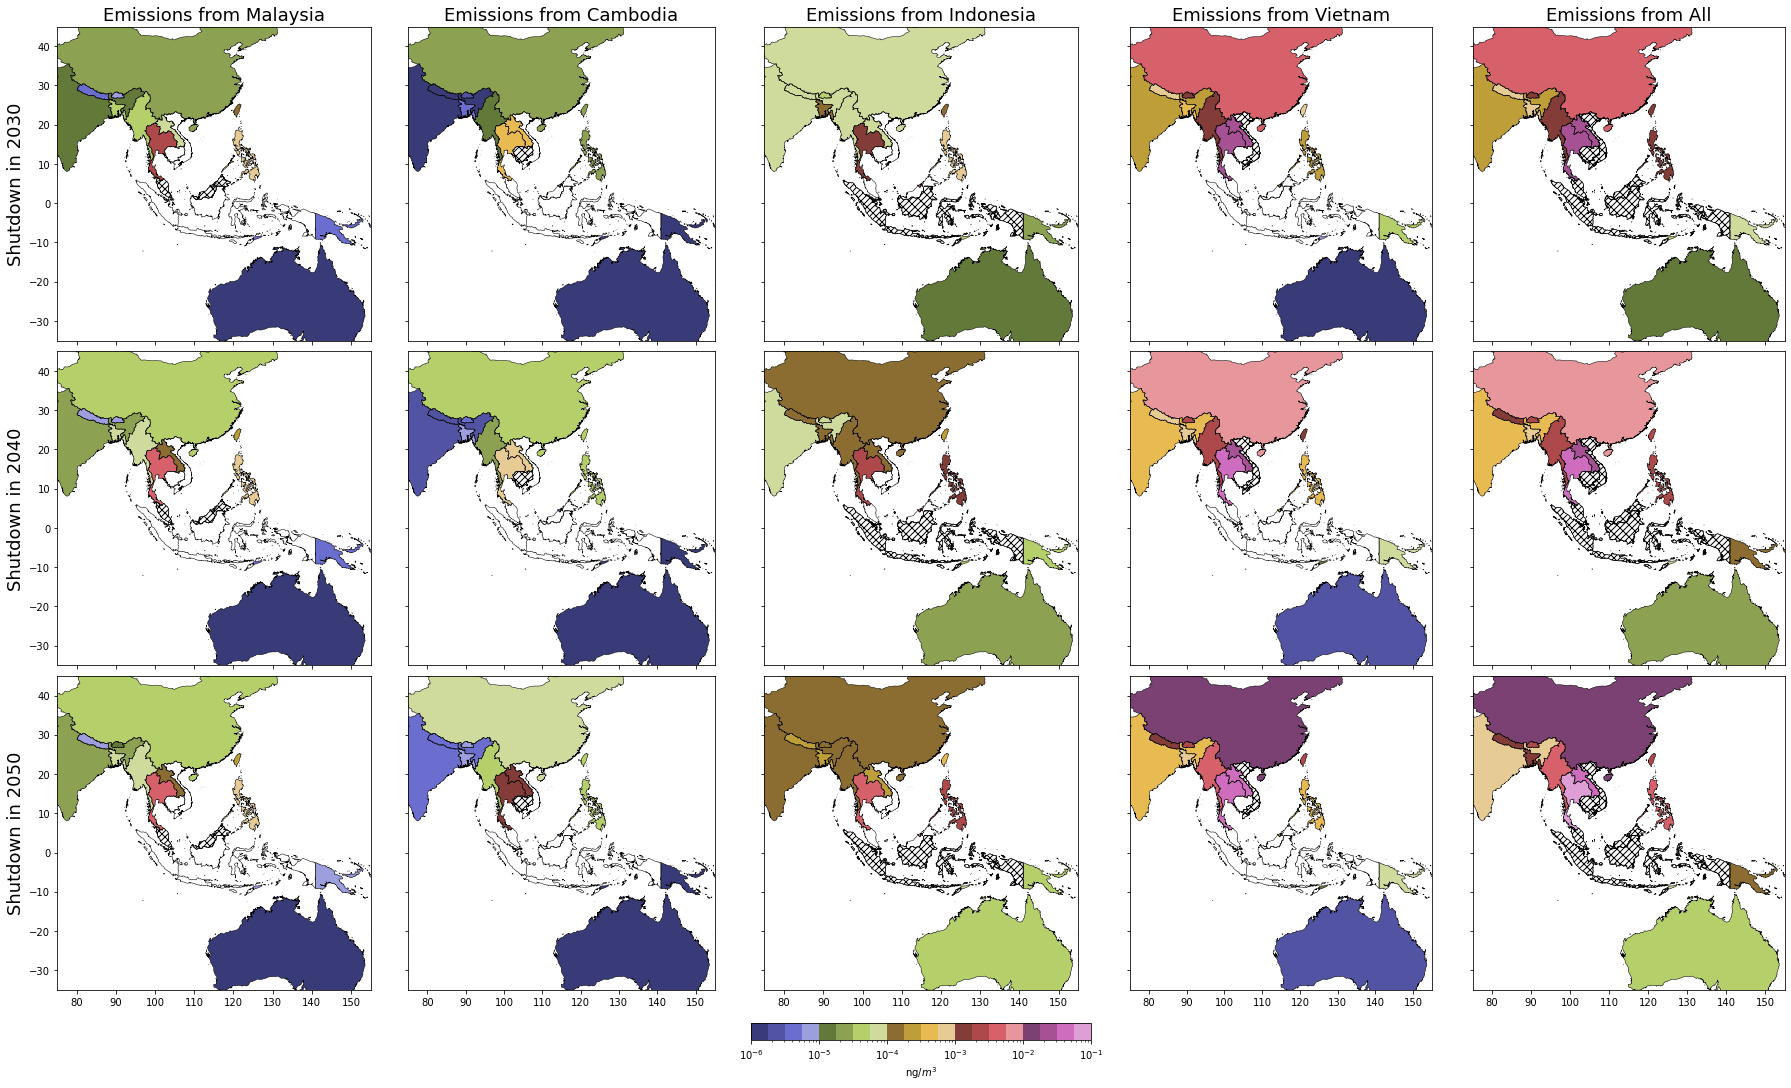

In [55]:
vmax_dict = {
    'MALAYSIA': 10,
    'CAMBODIA': 10,
    'INDONESIA': 100,
    'VIETNAM': 1000,
    'all': 1000,
    
}

fig, axes = plt.subplots(3,5, figsize = (25,15), sharex = True, sharey = True, constrained_layout = True)
for idx_m, loc in enumerate(map_locations):
    for idx_t, t in enumerate(np.arange(2030,2060)[::10]):
        ax = axes[idx_t,idx_m]
        if (idx_t == 2) & (idx_m == 2):
            bc_pop_weight_mean[loc][t].plot(ax = ax, column =  'BC_pop_weight_mean_conc', legend = True, cmap = 'tab20b',  norm=matplotlib.colors.LogNorm(vmin = 1e-6, vmax = 1e-1),
                                                legend_kwds={"orientation": "horizontal", "anchor":  (0.0, 1), 'fraction':0.1 , 'label':'ng/$m^3$'})
            country_df[country_df['country'].isin(all_countries)].boundary.plot(ax = ax, color = 'k', linewidth = .5)
        else:
            bc_pop_weight_mean[loc][t].plot(ax = ax, column =  'BC_pop_weight_mean_conc',  cmap = 'tab20b',  norm=matplotlib.colors.LogNorm(vmin = 1e-6, vmax = 1e-1))
            country_df[country_df['country'].isin(all_countries)].boundary.plot(ax = ax, color = 'k', linewidth = .5)
    
        if loc == 'MALAYSIA' or loc == 'CAMBODIA' or loc == 'INDONESIA' or loc == 'VIETNAM':
            country_df[country_df['country'] == loc.capitalize()].boundary.plot(ax = ax, color = 'k', linewidth = .5, hatch="\\\\////")
        
        if loc == 'all':
            country_df[country_df['country'].isin(['Vietnam','Indonesia','Cambodia','Malaysia'])].boundary.plot(ax = ax, color = 'k', linewidth = .5, hatch="\\\\////")
            
    
        axes[0,idx_m].set_title(f'Emissions from {loc.capitalize()}', fontsize = 18);
        axes[idx_t,0].set_ylabel(f'Shutdown in {t}', fontsize = 18);
        ax.set_xlim(75,155)
        ax.set_ylim(-35,45)
plt.savefig('figures/paper/maps.png', bbox_inches = 'tight', dpi = 300)

In [28]:
norm_bc_pop_weight_mean = {}
for loc in map_locations:
    print(loc)
    norm_bc_pop_weight_mean[loc] = {}
    for yr in shutdown_years:
        norm_bc_pop_weight_mean[loc][yr] = bc_pop_weight_mean[loc][yr].copy()
        
for loc in ['MALAYSIA', 'CAMBODIA', 'INDONESIA', 'VIETNAM']:
    print(loc)
    for yr in shutdown_years:
        norm_bc_pop_weight_mean[loc][yr]['BC_pop_weight_mean_conc'] = norm_bc_pop_weight_mean[loc][yr]['BC_pop_weight_mean_conc']/(CGP_df.groupby('COUNTRY').sum()['BC_(g/day)'][loc]*yr*365)
for yr in shutdown_years:        
    norm_bc_pop_weight_mean['all'][yr]['BC_pop_weight_mean_conc'] = norm_bc_pop_weight_mean['all'][yr]['BC_pop_weight_mean_conc']/(CGP_df.groupby('COUNTRY').sum()['BC_(g/day)'].sum()*yr*365)

MALAYSIA
CAMBODIA
INDONESIA
VIETNAM
all
MALAYSIA
CAMBODIA
INDONESIA
VIETNAM


In [50]:
map_locations

['MALAYSIA', 'CAMBODIA', 'INDONESIA', 'VIETNAM', 'all']

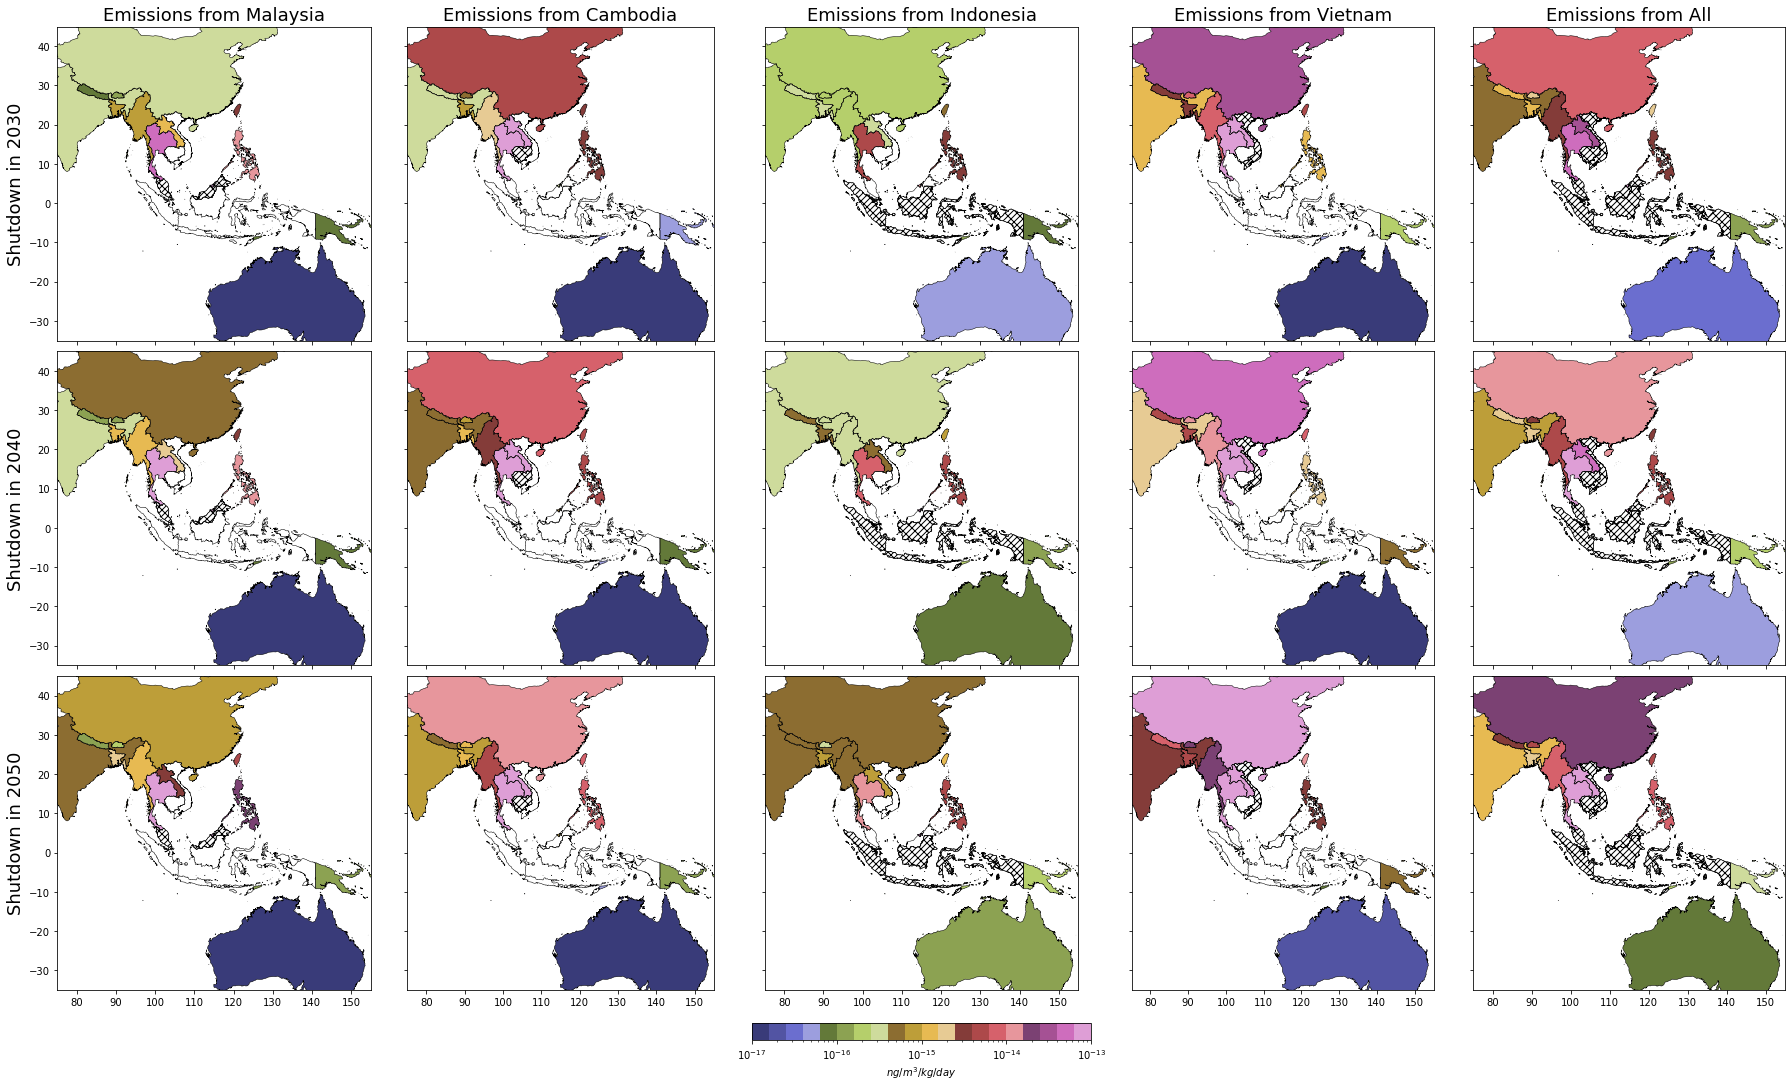

In [54]:
vmax_dict = {
    'MALAYSIA': 10,
    'CAMBODIA': 10,
    'INDONESIA': 100,
    'VIETNAM': 1000,
    'all': 1000,
    
}

fig, axes = plt.subplots(3,5, figsize = (25,15), sharex = True, sharey = True, constrained_layout = True)
for idx_m, loc in enumerate(map_locations):
    for idx_t, t in enumerate(np.arange(2030,2060)[::10]):
        
        ax = axes[idx_t,idx_m]
        if (idx_t == 2) & (idx_m == 2):
            (norm_bc_pop_weight_mean[loc][t]).plot(ax = ax, column =  'BC_pop_weight_mean_conc', legend = True, cmap = 'tab20b',  norm=matplotlib.colors.LogNorm(vmin = 1e-17, vmax = 1e-13),
                                                legend_kwds={"orientation": "horizontal", "anchor":  (0.0, 1), 'fraction':0.1 , 'label':r'$ng/m^3/kg/day$'})
            country_df[country_df['country'].isin(all_countries)].boundary.plot(ax = ax, color = 'k', linewidth = .5)
        else:
            (norm_bc_pop_weight_mean[loc][t]).plot(ax = ax, column =  'BC_pop_weight_mean_conc', cmap = 'tab20b',  norm=matplotlib.colors.LogNorm(vmin = 1e-17, vmax = 1e-13))
            country_df[country_df['country'].isin(all_countries)].boundary.plot(ax = ax, color = 'k', linewidth = .5)
        if loc == 'MALAYSIA' or loc == 'CAMBODIA' or loc == 'INDONESIA' or loc == 'VIETNAM':
            country_df[country_df['country'] == loc.capitalize()].boundary.plot(ax = ax, color = 'k', linewidth = .5, hatch="\\\\////")
        
        if loc == 'all':
            country_df[country_df['country'].isin(['Vietnam','Indonesia','Cambodia','Malaysia'])].boundary.plot(ax = ax, color = 'k', linewidth = .5, hatch="\\\\////")
            
        axes[0,idx_m].set_title(f'Emissions from {loc.capitalize()}', fontsize = 18);
        axes[idx_t,0].set_ylabel(f'Shutdown in {t}', fontsize = 18);
        ax.set_xlim(75,155)
        ax.set_ylim(-35,45)
plt.savefig('figures/paper/maps_normalized.png', bbox_inches = 'tight', dpi = 300)

## Datasets to analyze shutdown approach


In [59]:

age_ds = {}
bckg_age_ds = {}
for idx, val in enumerate(full_ds['unique_ID'].values):
    age_ds[idx] = full_ds.sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
    
    bckg_age_ds[idx] = full_ds.sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(idx, -1)).sum(dim = ['unique_ID'])
    
age_ds = xr.concat([age_ds[t] for t in age_ds.keys()], pd.Index([t for t in age_ds.keys()], name='unique_ID'), join = 'outer')
bckg_age_ds = xr.concat([bckg_age_ds[t] for t in bckg_age_ds.keys()], pd.Index([t for t in bckg_age_ds.keys()], name='unique_ID'), join = 'outer')


In [67]:
weighted_ds = {}
bckg_weighted_ds = {}
for idx, val in enumerate(full_ds['unique_ID'].values):
    weighted_ds[idx] = full_ds.sortby(
                     ['CO2_weighted_capacity_1000tonsperMW'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
    bckg_weighted_ds[idx] = full_ds.sortby(
                     ['CO2_weighted_capacity_1000tonsperMW'], ascending = True).isel(unique_ID = slice(idx, -1)).sum(dim = ['unique_ID'])
    
weighted_ds = xr.concat([weighted_ds[t] for t in weighted_ds.keys()], pd.Index([t for t in weighted_ds.keys()], name='unique_ID'), join = 'outer')
bckg_weighted_ds = xr.concat([bckg_weighted_ds[t] for t in bckg_weighted_ds.keys()], pd.Index([t for t in bckg_weighted_ds.keys()], name='unique_ID'), join = 'outer')


In [61]:
mw_ds = {}
bckg_mw_ds = {}
for idx, val in enumerate(full_ds['unique_ID'].values):
    mw_ds[idx] = full_ds.sortby(
                     ['MW'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
    bckg_mw_ds[idx] = full_ds.sortby(
                     ['MW'], ascending = True).isel(unique_ID = slice(idx, -1)).sum(dim = ['unique_ID'])
mw_ds = xr.concat([mw_ds[t] for t in mw_ds.keys()], pd.Index([t for t in mw_ds.keys()], name='unique_ID'), join = 'outer')
bckg_mw_ds = xr.concat([bckg_mw_ds[t] for t in bckg_mw_ds.keys()], pd.Index([t for t in bckg_mw_ds.keys()], name='unique_ID'), join = 'outer')


## Incorporating CO2 trajectories

temp_conv = 3*1e-12
co2_to_c = 1/3.67

dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
fig, axes = plt.subplots(1,3, figsize = (15,5), sharex = True, sharey = True, constrained_layout = True)
for idx_d, ds in enumerate([age_ds, weighted_ds, mw_ds]):
    ax = axes[idx_d]
    ####BC#######
    ds['BC_temp'].plot.contour(ax = ax, add_colorbar = True,  
                           #vmin = 0, vmax = dict_vmax[impacted_c], 
                              cmap = 'cividis',
                           cbar_kwargs = {'label':'W/m$^2$ forcing'})

    ####CO2######
    contours = (ds['co2_emissions']*co2_to_c*temp_conv).plot.contour(ax = ax, add_colorbar = False, cmap = 'gist_heat_r', 
                               )

    plt.clabel(contours, fontsize=8, inline = True)
    #### TITLES #####
    ax.set_title(None)
    ax.set_title(dict_ds[idx_d], fontsize = 14)
    ax.set_ylabel(None)
    ax.set_xlim(2020,2060)
    axes[0].set_ylabel(f'Number of Plants Operating', fontsize = 12);
    ax.set_xlabel(f'Year of Closure', fontsize = 12);
#plt.savefig('figures/paper/contours_mw.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
dict_vmax = {'China':220, 'India': 12, 'Philippines':70}
fig, axes = plt.subplots(3,3, figsize = (15,10), sharex = True, sharey = True, constrained_layout = True)
for idx, impacted_c in enumerate(subset_locations):
    for idx_d, ds in enumerate([age_ds, weighted_ds, mw_ds]):
        ax = axes[idx,idx_d]
        ####BC#######
        ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c).plot(ax = ax, add_colorbar = True,  
                                                                                       #vmin = 0, vmax = dict_vmax[impacted_c], 
                                                                                          cmap = 'cividis',
                                                                                       cbar_kwargs = {'label':'Population weighted ng/m$^3$'})
        
        ####CO2######
        contours = (ds['MW_total']/1e6).plot.contour(ax = ax, add_colorbar = False, cmap = 'gist_heat_r', 
                                   levels = np.linspace(0,1, 11))
        
        plt.clabel(contours, fontsize=8, inline = True)
        #### TITLES #####
        ax.set_title(None)
        axes[0,idx_d].set_title(dict_ds[idx_d], fontsize = 14)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.set_xlim(2020,2060)
        axes[idx,0].text(-0.1, 1.06, impacted_c, transform=axes[idx,0].transAxes, fontsize = 12)
        axes[idx,0].set_ylabel(f'Number of Plants Operating', fontsize = 12);
        axes[2, idx_d].set_xlabel(f'Year of Closure', fontsize = 12);
#plt.savefig('figures/paper/contours_mw.png', bbox_inches = 'tight', dpi = 300)

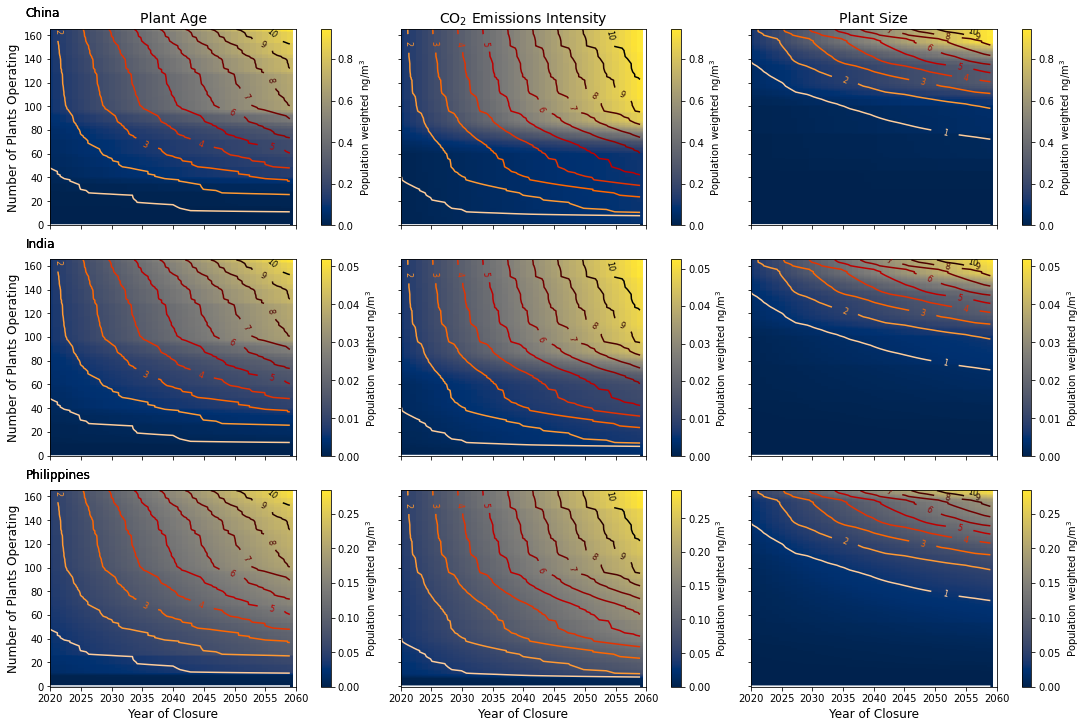

In [257]:
dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
dict_vmax = {'China':220, 'India': 12, 'Philippines':70}
fig, axes = plt.subplots(3,3, figsize = (15,10), sharex = True, sharey = True, constrained_layout = True)
for idx, impacted_c in enumerate(subset_locations):
    for idx_d, ds in enumerate([age_ds, weighted_ds, mw_ds]):
        ax = axes[idx,idx_d]
        ####BC#######
        ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c).plot(ax = ax, add_colorbar = True,  
                                                                                       #vmin = 0, vmax = dict_vmax[impacted_c], 
                                                                                          cmap = 'cividis',
                                                                                       cbar_kwargs = {'label':'Population weighted ng/m$^3$'})
        
        ####CO2######
        contours = (ds['co2_emissions']*1e-9).plot.contour(ax = ax, add_colorbar = False, cmap = 'gist_heat_r', 
                                   levels = np.linspace(0,10,11))
        
        plt.clabel(contours, fontsize=8, inline = True)
        #### TITLES #####
        ax.set_title(None)
        axes[0,idx_d].set_title(dict_ds[idx_d], fontsize = 14)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.set_xlim(2020,2060)
        axes[idx,0].text(-0.1, 1.06, impacted_c, transform=axes[idx,0].transAxes, fontsize = 12)
        axes[idx,0].set_ylabel(f'Number of Plants Operating', fontsize = 12);
        axes[2, idx_d].set_xlabel(f'Year of Closure', fontsize = 12);
plt.savefig('figures/paper/contours.png', bbox_inches = 'tight', dpi = 300)

## Just china

In [108]:
import string

[21.07352941 21.06735294 21.06117647 21.055      21.04882353 21.04213235
 21.03625    21.03036765 21.01786765 21.00463235 20.77816176 20.54139706
 20.30463235 20.28522059 20.26580882 20.24669118 20.22757353 20.21610294
 20.10139706 19.98669118 19.98095588 19.96948529 19.95801471 19.95205882
 19.94927941 19.9465     19.62558088 19.30466176 19.25775    19.21083824
 19.07607353 19.06541176 19.05475    19.04771324 19.04067647 18.90832353
 18.77597059 18.63655882 18.63391176 18.47891176 18.34214706 18.19170588
 17.82405882 17.68045588 17.67794853 17.67544118 17.525      17.37455882
 17.22411765 17.06911765 17.00073529 16.93235294 16.92779412 16.92323529
 16.61264706 16.58205882 16.55147059 16.40323529 16.29970588 16.135
 16.03147059 15.97264706 15.91382353 15.88227941 15.85073529 15.69786765
 15.545      15.39213235 15.23926471 15.06941176 15.06140441 15.05339706
 14.90780882 14.76222059 14.60935294 14.55597059 14.40310294 14.25310294
 14.23810294 14.18210294 14.12610294 13.97610294 13.8261

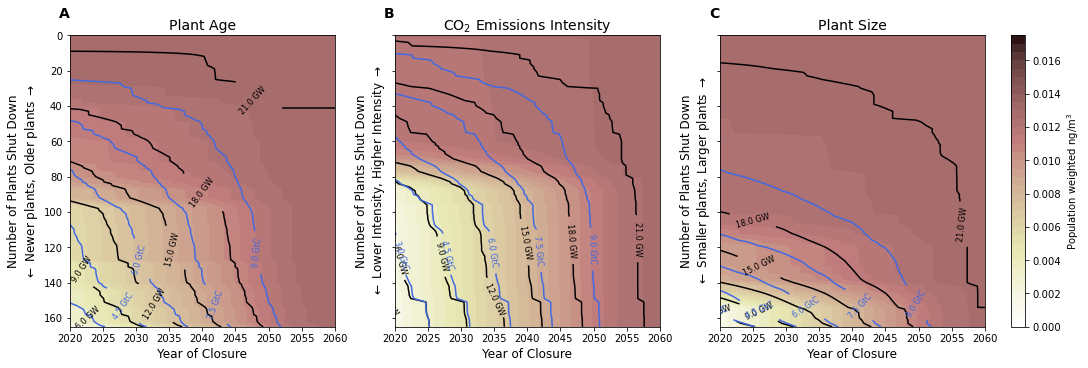

In [123]:
impacted_c = 'China'
dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
dict_vmax = {'China':220, 'India': 12, 'Philippines':70}
background_dict = {0:bckg_age_ds, 1: bckg_weight_ds, 2: bckg_mw_ds}
fig, axes = plt.subplots(1,3, figsize = (15,5), sharex = True, sharey = True, constrained_layout = True)
for idx_d, ds in enumerate([age_ds, weighted_ds, mw_ds]):
    ax = axes[idx_d]
    c = ax.contourf(ds['closure_year'].values,
            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
        (ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c) + background_dict[idx_d]['final_BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c)), 
                                                                               levels = np.arange(0,0.018,.0005), 
                                                                                  cmap = 'pink_r')

    ####CO2######
    contours = ax.contour(ds['closure_year'].values,
                            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
                            (ds['MW_total']+background_dict[idx_d]['final_MW_total'])/1e3, 
                            colors = 'k', 
                               #levels = np.arange(0,.1, .2)
                                                                               )
    strings = [str(np.round(i,1)) + ' GW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = ax.contour(ds['closure_year'].values,
                            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
                (ds['co2_emissions']+background_dict[idx_d]['final_co2_emissions'])*1e-9, 
                colors = 'royalblue', #levels = np.arange(0,14,2) 
                         )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
    #### TITLES #####
    ax.set_title(dict_ds[idx_d], fontsize = 14)
    ax.set_xlabel(f'Year of Closure', fontsize = 12)
    ax.set_xlim(2020,2060)
    axes[0].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);
    axes[1].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Lower Intensity, Higher Intensity $\rightarrow$', fontsize = 12);
    axes[2].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Smaller plants, Larger plants $\rightarrow$', fontsize = 12);

    ax.text(-0.04, 1.06, string.ascii_uppercase[idx_d], transform=ax.transAxes, 
            size=14, weight='bold')
    
    ax.invert_yaxis()
plt.colorbar(c, label ='Population weighted ng/m$^3$')
plt.savefig('figures/paper/contours_china.png', bbox_inches = 'tight', dpi = 300)

## Just china from Vietnam

In [114]:
vietnam_ds = full_ds.where(full_ds.country_emitting == 'VIETNAM', drop = True)

In [115]:

vietnam_age_ds = {}
bckg_vietnam_age_ds = {}
for idx, val in enumerate(vietnam_ds['unique_ID'].values):
    vietnam_age_ds[idx] = vietnam_ds.sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
    bckg_vietnam_age_ds[idx] = vietnam_ds.sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(idx, -1)).sum(dim = ['unique_ID'])
    
vietnam_age_ds = xr.concat([vietnam_age_ds[t] for t in vietnam_age_ds.keys()], pd.Index([t for t in vietnam_age_ds.keys()], name='unique_ID'), join = 'outer')
bckg_vietnam_age_ds = xr.concat([bckg_vietnam_age_ds[t] for t in bckg_vietnam_age_ds.keys()], pd.Index([t for t in bckg_vietnam_age_ds.keys()], name='unique_ID'), join = 'outer')

vietnam_weighted_ds = {}
bckg_vietnam_weighted_ds = {}
for idx, val in enumerate(vietnam_ds['unique_ID'].values):
    vietnam_weighted_ds[idx] = vietnam_ds.sortby(
                     ['CO2_weighted_capacity_1000tonsperMW'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
    bckg_vietnam_weighted_ds[idx] = vietnam_ds.sortby(
                     ['CO2_weighted_capacity_1000tonsperMW'], ascending = True).isel(unique_ID = slice(idx, -1)).sum(dim = ['unique_ID'])
    
vietnam_weighted_ds = xr.concat([vietnam_weighted_ds[t] for t in vietnam_weighted_ds.keys()], pd.Index([t for t in vietnam_weighted_ds.keys()], name='unique_ID'), join = 'outer')
bckg_vietnam_weighted_ds = xr.concat([bckg_vietnam_weighted_ds[t] for t in bckg_vietnam_weighted_ds.keys()], pd.Index([t for t in bckg_vietnam_weighted_ds.keys()], name='unique_ID'), join = 'outer')

vietnam_mw_ds = {}
bckg_vietnam_mw_ds = {}
for idx, val in enumerate(vietnam_ds['unique_ID'].values):
    vietnam_mw_ds[idx] = vietnam_ds.sortby(
                     ['MW'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
    bckg_vietnam_mw_ds[idx] = vietnam_ds.sortby(
                     ['MW'], ascending = True).isel(unique_ID = slice(idx, -1)).sum(dim = ['unique_ID'])
    
vietnam_mw_ds = xr.concat([vietnam_mw_ds[t] for t in vietnam_mw_ds.keys()], pd.Index([t for t in vietnam_mw_ds.keys()], name='unique_ID'), join = 'outer')
bckg_vietnam_mw_ds = xr.concat([bckg_vietnam_mw_ds[t] for t in bckg_vietnam_mw_ds.keys()], pd.Index([t for t in bckg_vietnam_mw_ds.keys()], name='unique_ID'), join = 'outer')


dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
fig, axes = plt.subplots(1,3, figsize = (15,5), sharex = True, sharey = True, constrained_layout = True)
for idx_d, ds in enumerate([vietnam_age_ds, vietnam_weighted_ds, vietnam_mw_ds]):
    ax = axes[idx_d]
    ####BC#######
    contours = ds['BC_forcing'].plot.contour(ax = ax, add_colorbar = False,  
                           #vmin = 0, vmax = dict_vmax[impacted_c], 
                              cmap = 'green')
    plt.clabel(contours, fontsize=8, inline = True)
    ####CO2######
    contours = (ds['co2_emissions']*1e-9).plot.contour(ax = ax, add_colorbar = False, cmap = 'black', 
                               levels = np.linspace(0,2.5, 6))

    plt.clabel(contours, fontsize=8, inline = True)
    #### TITLES #####
    ax.set_title(None)
    ax.set_title(dict_ds[idx_d], fontsize = 14)
    ax.set_ylabel(None)
    ax.set_xlim(2020,2060)
    axes[0].set_ylabel(f'Number of Plants Operating', fontsize = 12);
    ax.set_xlabel(f'Year of Closure', fontsize = 12);
#plt.savefig('figures/paper/contours_mw.png', bbox_inches = 'tight', dpi = 300)

1.7324025263854916
4.8058676470588235
0.007436095322643792
1.7732556948883265
4.952375
0.007681128599268956
1.7201962924214913
4.762963235294117
0.007416626059265936


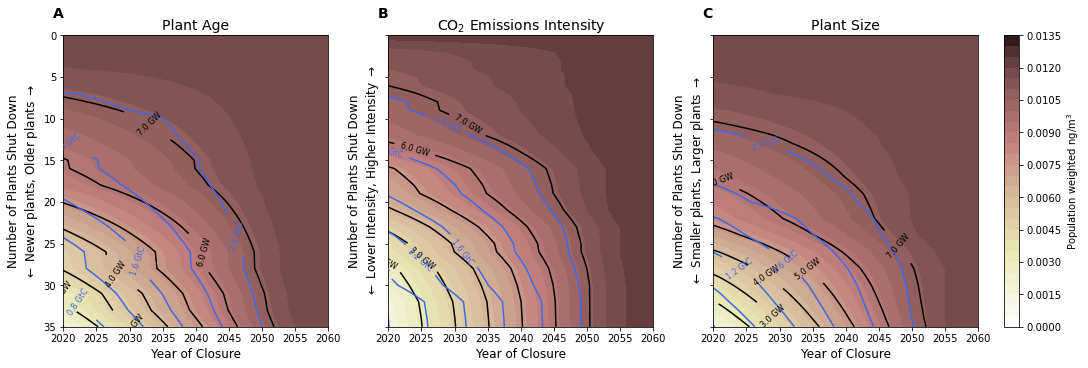

In [120]:
impacted_c = 'China'
dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
dict_vmax = {'China':220, 'India': 12, 'Philippines':70}
background_dict = {0:bckg_vietnam_age_ds, 1: bckg_vietnam_weighted_ds, 2: bckg_vietnam_mw_ds}
fig, axes = plt.subplots(1,3, figsize = (15,5), sharex = True, sharey = True, constrained_layout = True)
for idx_d, ds in enumerate([vietnam_age_ds, vietnam_weighted_ds, vietnam_mw_ds]):
    ax = axes[idx_d]
    c = ax.contourf(ds['closure_year'].values,
            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
        (ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c) + background_dict[idx_d]['final_BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c)), 
                                                                               levels = np.arange(0,0.014,.0005), 
                                                                                  cmap = 'pink_r')

    ####CO2######
    contours = ax.contour(ds['closure_year'].values,
                            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
                            (ds['MW_total']+background_dict[idx_d]['final_MW_total'])/1e3, 
                            colors = 'k', 
                               #levels = np.arange(0,.8, .1)
                                                                               )
    strings = [str(np.round(i,1)) + ' GW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = ax.contour(ds['closure_year'].values,
                            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
                (ds['co2_emissions']+background_dict[idx_d]['final_co2_emissions'])*1e-9, 
                colors = 'royalblue', #levels = np.arange(0,6,0.5) 
                         )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
    #### TITLES #####
    ax.set_title(dict_ds[idx_d], fontsize = 14)
    ax.set_xlabel(f'Year of Closure', fontsize = 12)
    ax.set_xlim(2020,2060)
    axes[0].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);
    axes[1].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Lower Intensity, Higher Intensity $\rightarrow$', fontsize = 12);
    axes[2].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Smaller plants, Larger plants $\rightarrow$', fontsize = 12);

    ax.text(-0.04, 1.06, string.ascii_uppercase[idx_d], transform=ax.transAxes, 
            size=14, weight='bold')
    
    ax.invert_yaxis()
    print((ds['co2_emissions']+background_dict[idx_d]['final_co2_emissions']).sel(closure_year = 2040, unique_ID = 35).values/1e9)
    print((ds['MW_total']+background_dict[idx_d]['final_MW_total']).sel(closure_year = 2040, unique_ID = 35).values/1e3)
    print((ds['BC_pop_weight_mean_conc']+background_dict[idx_d]['final_BC_pop_weight_mean_conc']).sel(country_impacted = impacted_c).sel(closure_year = 2040, unique_ID = 35).values)

plt.colorbar(c, label ='Population weighted ng/m$^3$')
plt.savefig('figures/paper/contours_china_from_vietnam.png', bbox_inches = 'tight', dpi = 300)

## Just oldest plants from all countries

In [114]:


malay_age_ds = {}
for idx in np.arange(0,len(full_ds.where(full_ds.country_emitting == 'MALAYSIA', drop = True)['unique_ID'])):
    malay_age_ds[idx] = full_ds.where(full_ds.country_emitting == 'MALAYSIA', drop = True).sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
malay_age_ds = xr.concat([malay_age_ds[t] for t in malay_age_ds.keys()], pd.Index([t for t in malay_age_ds.keys()], name='num_plants_comis_yr'), join = 'outer')



cambod_age_ds = {}
for idx in np.arange(0,len(full_ds.where(full_ds.country_emitting == 'CAMBODIA', drop = True)['unique_ID'])):
    cambod_age_ds[idx] = full_ds.where(full_ds.country_emitting == 'CAMBODIA', drop = True).sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
cambod_age_ds = xr.concat([cambod_age_ds[t] for t in cambod_age_ds.keys()], pd.Index([t for t in cambod_age_ds.keys()], name='num_plants_comis_yr'), join = 'outer')



indo_age_ds = {}
for idx in np.arange(0,len(full_ds.where(full_ds.country_emitting == 'INDONESIA', drop = True)['unique_ID'])):
    indo_age_ds[idx] = full_ds.where(full_ds.country_emitting == 'INDONESIA', drop = True).sortby(
                     ['Year_of_Commission'], ascending = True).isel(unique_ID = slice(0,idx)).sum(dim = ['unique_ID'])
indo_age_ds = xr.concat([indo_age_ds[t] for t in indo_age_ds.keys()], pd.Index([t for t in indo_age_ds.keys()], name='num_plants_comis_yr'), join = 'outer')


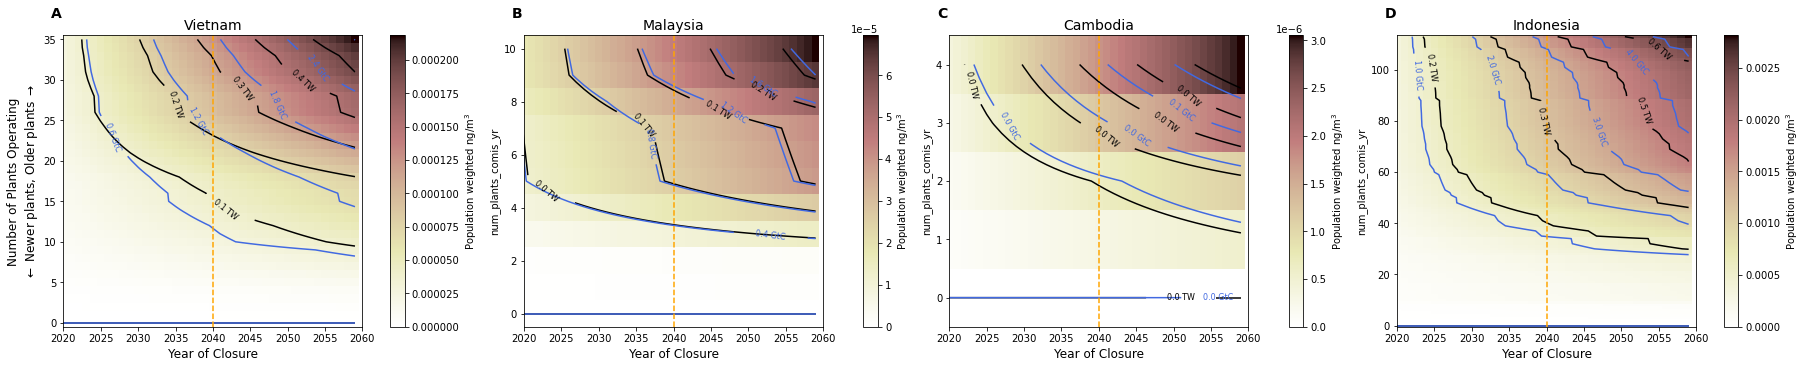

In [118]:
impacted_c = 'Australia'
dict_ds = {0:'Vietnam', 1: 'Malaysia', 2: 'Cambodia', 3: 'Indonesia'}
dict_vmax = {'China':220, 'India': 12, 'Philippines':70}
fig, axes = plt.subplots(1,4, figsize = (25,5), sharex = True, sharey = False, constrained_layout = True)
for idx_d, ds in enumerate([viet_age_ds, malay_age_ds, cambod_age_ds, indo_age_ds]):
    idx = 0
    ax = axes[idx_d]
    ####BC#######
    ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c).plot(ax = ax, add_colorbar = True,  
                                                                                   #vmin = 0, vmax = 0.8, 
                                                                                      cmap = 'pink_r',
                                                                                    cbar_kwargs = {'label':'Population weighted ng/m$^3$'})
   
    ####CO2######
    contours = (ds['MW_total']/1e6).plot.contour(ax = ax, add_colorbar = False, cmap = 'k', 
                              # levels = np.linspace(0,.5, 6)
                                                )
    strings = [str(np.round(i,1)) + ' TW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = (ds['co2_emissions']*1e-9).plot.contour(ax = ax, add_colorbar = False, cmap = 'royalblue', 
                              # levels = np.linspace(0,2.5,6)
                                                      )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
    #### TITLES #####
    ax.set_title(dict_ds[idx_d], fontsize = 14)
    ax.set_xlabel(f'Year of Closure', fontsize = 12)
    ax.set_xlim(2020,2060)
    axes[0].set_ylabel('Number of Plants Operating\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);

    ax.text(-0.04, 1.06, string.ascii_uppercase[idx_d], transform=ax.transAxes, 
            size=14, weight='bold')
    ax.axvline(2040, linestyle = '--', color = 'orange')
#plt.savefig('figures/paper/contours_china_from_vietnam.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
impacted_c = 'China'
dict_ds = {0:'Plant Age', 1: 'CO$_2$ Emissions Intensity', 2: 'Plant Size'}
dict_vmax = {'China':220, 'India': 12, 'Philippines':70}
background_dict = {0:bckg_vietnam_age_ds, 1: bckg_vietnam_weighted_ds, 2: bckg_vietnam_mw_ds}
fig, axes = plt.subplots(1,3, figsize = (15,5), sharex = True, sharey = True, constrained_layout = True)
for idx_d, ds in enumerate([vietnam_age_ds, vietnam_weighted_ds, vietnam_mw_ds]):
    ax = axes[idx_d]
    c = ax.contourf(ds['closure_year'].values,
            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
        (ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c) + background_dict[idx_d]['final_BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c)), 
                                                                               levels = np.arange(0,0.014,.0005), 
                                                                                  cmap = 'pink_r')

    ####CO2######
    contours = ax.contour(ds['closure_year'].values,
                            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
                            (ds['MW_total']+background_dict[idx_d]['final_MW_total'])/1e3, 
                            colors = 'k', 
                               #levels = np.arange(0,.8, .1)
                                                                               )
    strings = [str(np.round(i,1)) + ' GW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = ax.contour(ds['closure_year'].values,
                            np.arange(0, len((ds['MW_total']+background_dict[idx_d])['unique_ID'])),
                (ds['co2_emissions']+background_dict[idx_d]['final_co2_emissions'])*1e-9, 
                colors = 'royalblue', #levels = np.arange(0,6,0.5) 
                         )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
    #### TITLES #####
    ax.set_title(dict_ds[idx_d], fontsize = 14)
    ax.set_xlabel(f'Year of Closure', fontsize = 12)
    ax.set_xlim(2020,2060)
    axes[0].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);
    axes[1].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Lower Intensity, Higher Intensity $\rightarrow$', fontsize = 12);
    axes[2].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Smaller plants, Larger plants $\rightarrow$', fontsize = 12);

    ax.text(-0.04, 1.06, string.ascii_uppercase[idx_d], transform=ax.transAxes, 
            size=14, weight='bold')
    
    ax.invert_yaxis()
    print((ds['co2_emissions']+background_dict[idx_d]['final_co2_emissions']).sel(closure_year = 2040, unique_ID = 35).values/1e9)
    print((ds['MW_total']+background_dict[idx_d]['final_MW_total']).sel(closure_year = 2040, unique_ID = 35).values/1e3)
    print((ds['BC_pop_weight_mean_conc']+background_dict[idx_d]['final_BC_pop_weight_mean_conc']).sel(country_impacted = impacted_c).sel(closure_year = 2040, unique_ID = 35).values)

plt.colorbar(c, label ='Population weighted ng/m$^3$')
plt.savefig('figures/paper/contours_china_from_vietnam.png', bbox_inches = 'tight', dpi = 300)

/tmp/ipykernel_552/789825327.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(a)


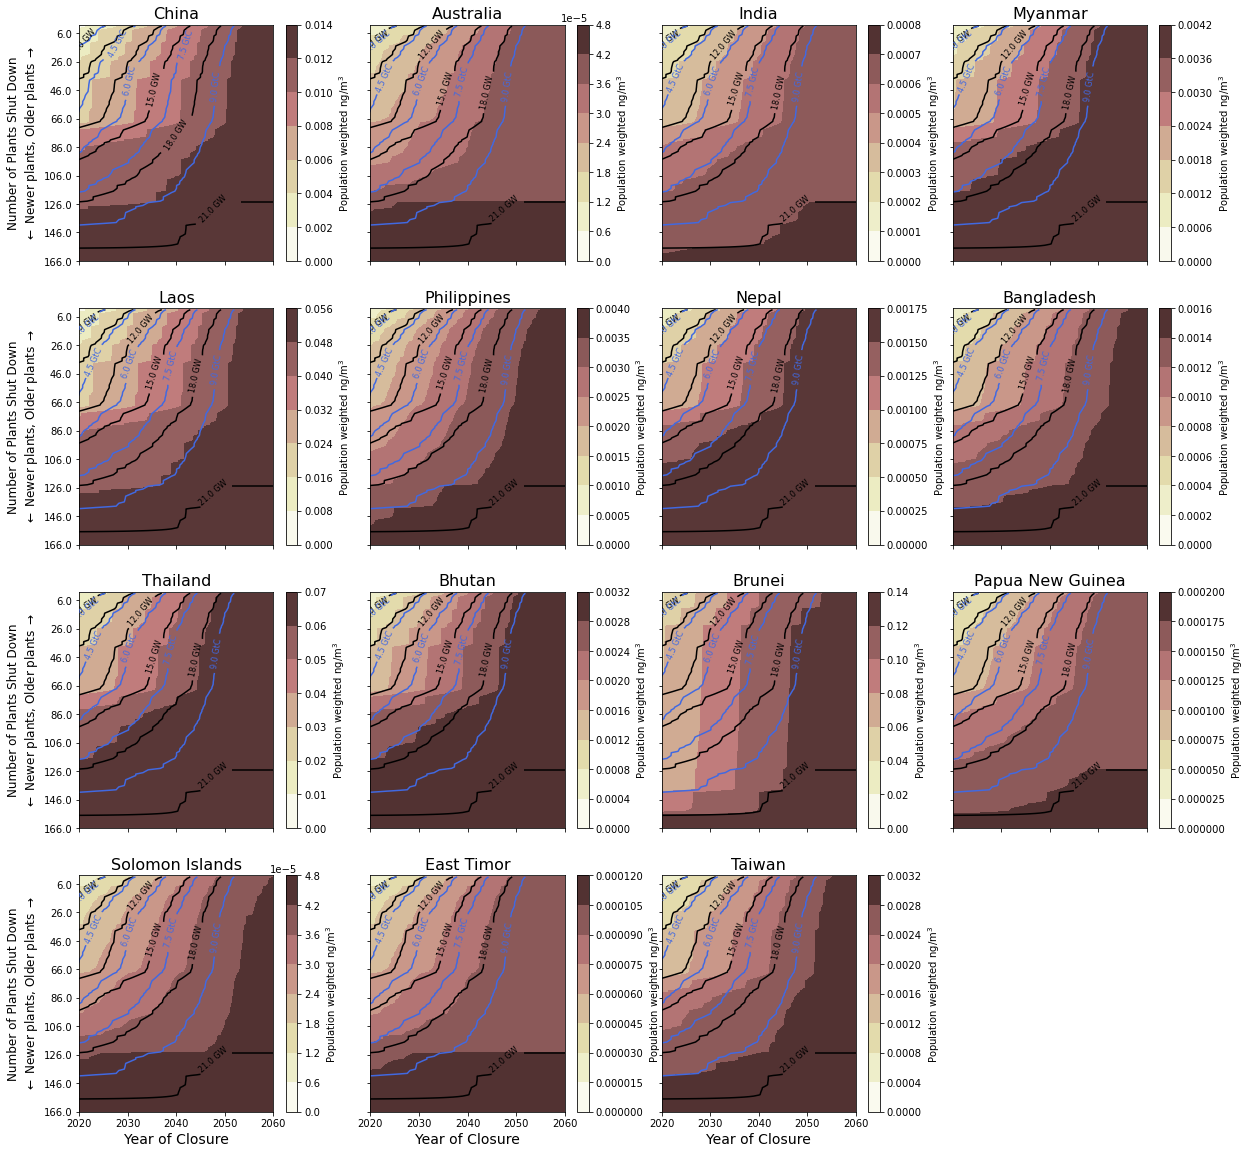

In [65]:
fig, axes = plt.subplots(4,4, figsize = (20,20), sharex = True, sharey = True)
for ax, impacted_c in zip(axes.ravel(), impacted_countries):
    c = ax.contourf(age_ds['closure_year'].values,
            np.arange(0, len((age_ds['MW_total']+bckg_age_ds)['unique_ID'])),
        (age_ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c) + bckg_age_ds['final_BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c)), 
                                                                               #levels = np.arange(0,0.014,.0005), 
                                                                                  cmap = 'pink_r')
    plt.colorbar(c, ax = ax, label ='Population weighted ng/m$^3$')
    ####CO2######
    contours = ax.contour(age_ds['closure_year'].values,
                            np.arange(0, len((age_ds['MW_total']+bckg_age_ds)['unique_ID'])),
                            (age_ds['MW_total']+bckg_age_ds['final_MW_total'])/1e3, 
                            colors = 'k', 
                               #levels = np.arange(0,.8, .1)
                                                                               )
    strings = [str(np.round(i,1)) + ' GW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = ax.contour(age_ds['closure_year'].values,
                            np.arange(0, len((age_ds['MW_total']+bckg_age_ds)['unique_ID'])),
                (age_ds['co2_emissions']+bckg_age_ds['final_co2_emissions'])*1e-9, 
                colors = 'royalblue', #levels = np.arange(0,6,0.5) 
                         )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
        
    ax.set_title(impacted_c, fontsize = 16)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xlim(2020,2060)
for idx in np.arange(0,4):
    axes[idx,0].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);

    axes[3, idx].set_xlabel(f'Year of Closure', fontsize = 14);
    

    ax.set_ylim(0,166)
    a = ax.get_yticks().tolist()
    for idx, num in enumerate(a):
        a[idx] = 166 - num
    ax.set_yticklabels(a)
    
fig.delaxes(axes[3,3])
plt.savefig('figures/supplement/supp_age_retire_all.png', bbox_inches = 'tight', dpi = 300)



/tmp/ipykernel_552/3153466768.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(a)


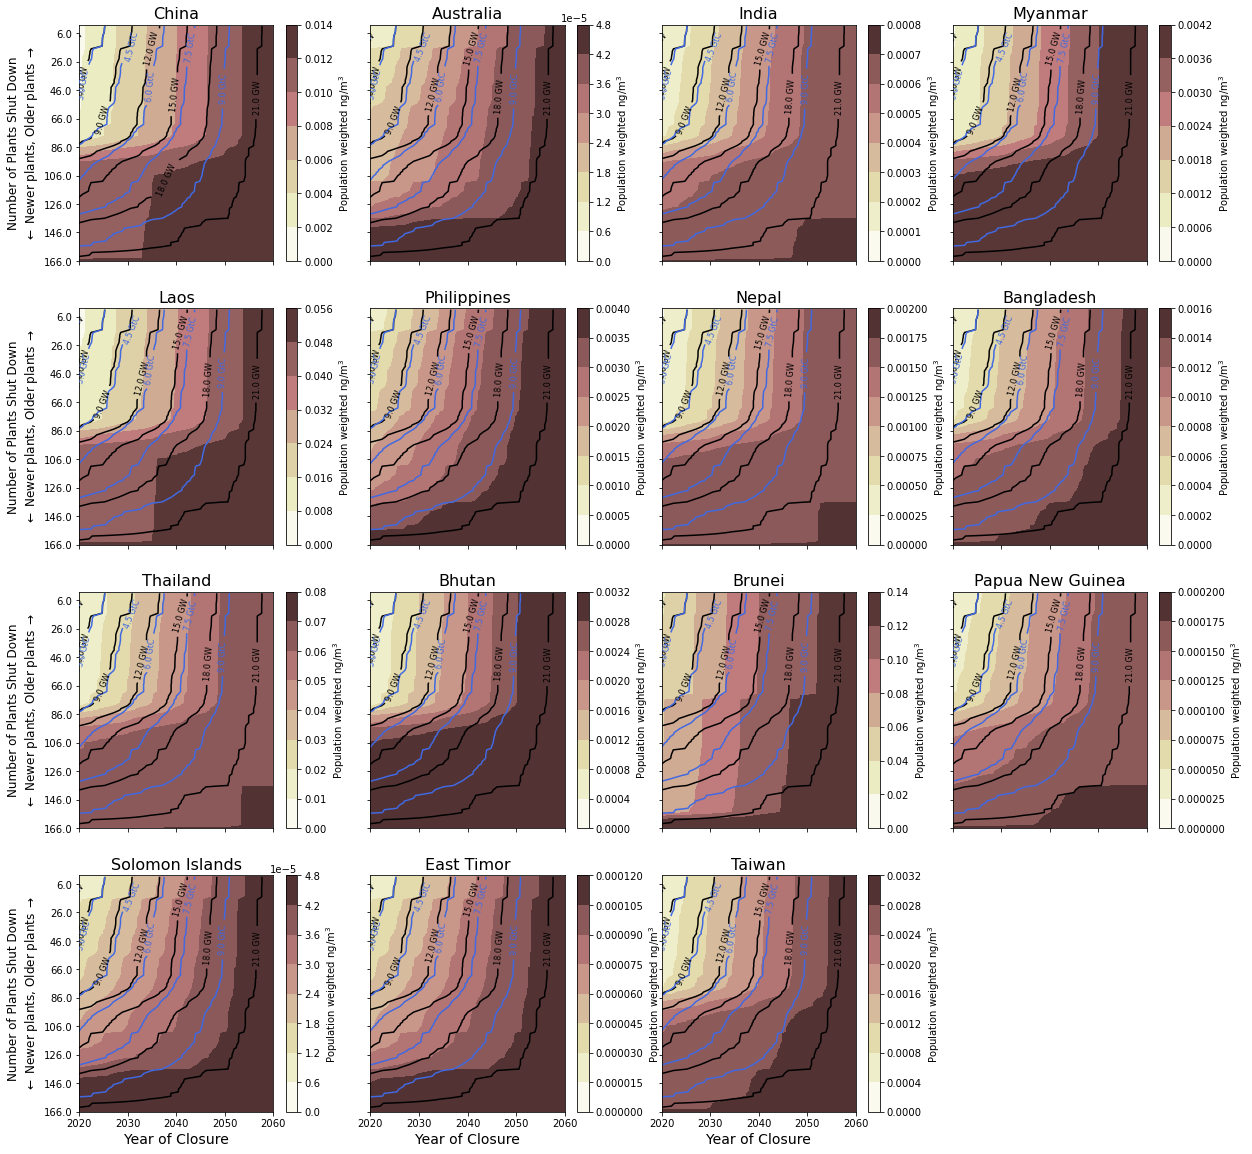

In [69]:
fig, axes = plt.subplots(4,4, figsize = (20,20), sharex = True, sharey = True)
for ax, impacted_c in zip(axes.ravel(), impacted_countries):
    c = ax.contourf(weighted_ds['closure_year'].values,
            np.arange(0, len((weighted_ds['MW_total']+bckg_weighted_ds)['unique_ID'])),
        (weighted_ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c) + bckg_weighted_ds['final_BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c)), 
                                                                               #levels = np.arange(0,0.014,.0005), 
                                                                                  cmap = 'pink_r')
    plt.colorbar(c, ax = ax, label ='Population weighted ng/m$^3$')
    ####CO2######
    contours = ax.contour(weighted_ds['closure_year'].values,
                            np.arange(0, len((weighted_ds['MW_total']+bckg_weighted_ds)['unique_ID'])),
                            (weighted_ds['MW_total']+bckg_weighted_ds['final_MW_total'])/1e3, 
                            colors = 'k', 
                               #levels = np.arange(0,.8, .1)
                                                                               )
    strings = [str(np.round(i,1)) + ' GW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = ax.contour(weighted_ds['closure_year'].values,
                            np.arange(0, len((weighted_ds['MW_total']+bckg_weighted_ds)['unique_ID'])),
                (weighted_ds['co2_emissions']+bckg_weighted_ds['final_co2_emissions'])*1e-9, 
                colors = 'royalblue', #levels = np.arange(0,6,0.5) 
                         )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
        
    ax.set_title(impacted_c, fontsize = 16)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xlim(2020,2060)
for idx in np.arange(0,4):
    axes[idx,0].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);

    axes[3, idx].set_xlabel(f'Year of Closure', fontsize = 14);
    

    ax.set_ylim(0,166)
    a = ax.get_yticks().tolist()
    for idx, num in enumerate(a):
        a[idx] = 166 - num
    ax.set_yticklabels(a)
    
fig.delaxes(axes[3,3])

plt.savefig('figures/supplement/supp_emisfactor_co2_all.png', bbox_inches = 'tight', dpi = 300)



/tmp/ipykernel_552/1070408945.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(a)


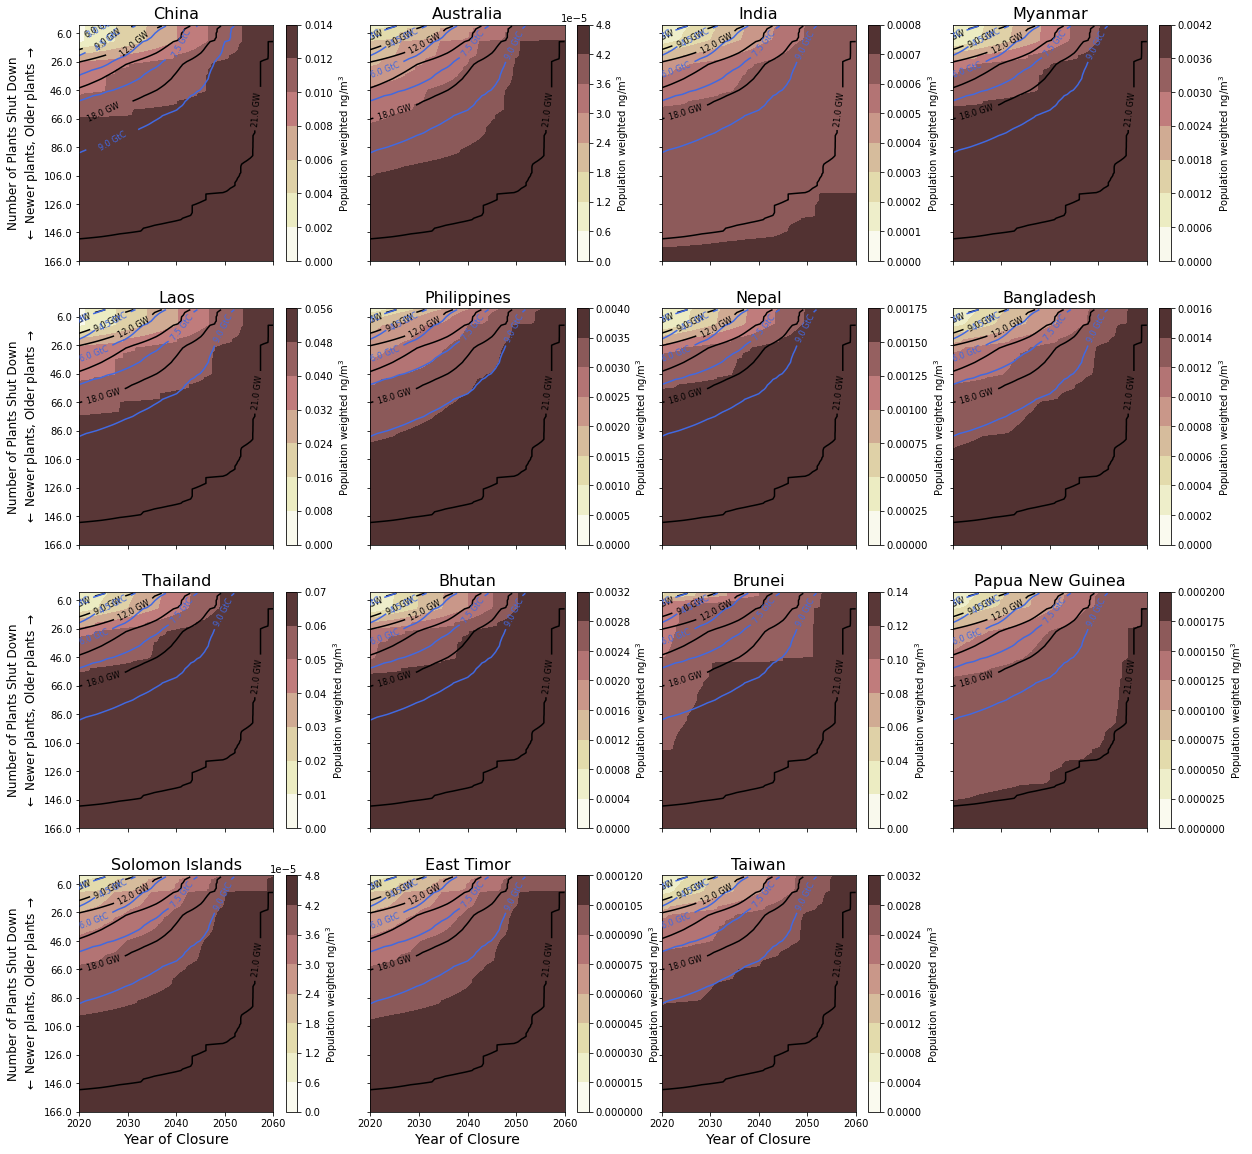

In [70]:
fig, axes = plt.subplots(4,4, figsize = (20,20), sharex = True, sharey = True)
for ax, impacted_c in zip(axes.ravel(), impacted_countries):
    c = ax.contourf(mw_ds['closure_year'].values,
            np.arange(0, len((mw_ds['MW_total']+bckg_mw_ds)['unique_ID'])),
        (mw_ds['BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c) + bckg_mw_ds['final_BC_pop_weight_mean_conc'].sel(country_impacted = impacted_c)), 
                                                                               #levels = np.arange(0,0.014,.0005), 
                                                                                  cmap = 'pink_r')
    plt.colorbar(c, ax = ax, label ='Population weighted ng/m$^3$')
    ####CO2######
    contours = ax.contour(mw_ds['closure_year'].values,
                            np.arange(0, len((mw_ds['MW_total']+bckg_mw_ds)['unique_ID'])),
                            (mw_ds['MW_total']+bckg_mw_ds['final_MW_total'])/1e3, 
                            colors = 'k', 
                               #levels = np.arange(0,.8, .1)
                                                                               )
    strings = [str(np.round(i,1)) + ' GW' for i in contours.levels ]
    fmt = {}
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)


    ####CO2######
    contours = ax.contour(mw_ds['closure_year'].values,
                            np.arange(0, len((mw_ds['MW_total']+bckg_mw_ds)['unique_ID'])),
                (mw_ds['co2_emissions']+bckg_mw_ds['final_co2_emissions'])*1e-9, 
                colors = 'royalblue', #levels = np.arange(0,6,0.5) 
                         )
    strings = [str(np.round(i,1)) + ' GtC' for i in contours.levels ]
    for l, s in zip(contours.levels, strings):
        fmt[l] = s
    plt.clabel(contours, fontsize=8, inline = True, fmt = fmt)
        
    ax.set_title(impacted_c, fontsize = 16)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xlim(2020,2060)
for idx in np.arange(0,4):
    axes[idx,0].set_ylabel('Number of Plants Shut Down\n' + r'$\leftarrow$ Newer plants, Older plants $\rightarrow$', fontsize = 12);

    axes[3, idx].set_xlabel(f'Year of Closure', fontsize = 14);
    

    ax.set_ylim(0,166)
    a = ax.get_yticks().tolist()
    for idx, num in enumerate(a):
        a[idx] = 166 - num
    ax.set_yticklabels(a)
    
fig.delaxes(axes[3,3])

plt.savefig('figures/supplement/supp_mw_all.png', bbox_inches = 'tight', dpi = 300)

